In [1]:
from card_game import CardGame, Player, Card
import random
from agents import REINFORCEAgent, ACAgent, Agent, PPOAgent
from tqdm import tqdm
import numpy as np
import torch as t
from typing import Tuple, Union
from harry_plotter import LearningCurvePlot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import asyncio
from tqdm.notebook import tqdm

cividis = cm.get_cmap('cividis')
viridis = cm.get_cmap('viridis')
%matplotlib widget
player = 1

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [3]:
!jupyter nbextension enable --py --sys-prefix ipympl

Enabling notebook extension jupyter-matplotlib/extension...
      - Validating: ok


In [4]:
class RandomPlayer(Player):
    """
    Makes random moves (but according to the rules)
    """
    def __init__(self):
        global player
        self.number = player
        player += 1

    def make_move(self, game_state: dict, was_previous_move_wrong: bool) -> Card:
        if not game_state["discard"]:
            return random.choice(game_state["hand"])
        else:
            options = list(filter(lambda card: card.suit == list(game_state["discard"])[0].suit, game_state["hand"]))
            if len(options) > 0:
                return random.choice(options)
            else:
                return random.choice(game_state["hand"])

    def get_name(self):
        return f"RandomPlayer{self.number}"

    def set_temp_reward(self, discarded_cards: dict, point_deltas: dict):
        pass

    def set_final_reward(self, points: dict):
        pass


In [5]:
min_loss = float('inf')
min_loss_baseline = float('inf')
min_loss_actor = float('inf')
min_loss_critic = float('inf')
min_loss_actor_ppo = float('inf')
min_loss_critic_ppo = float('inf')

In [6]:
def plot_loss_ac(loss: Tuple[float, float], agent: ACAgent, plot:LearningCurvePlot):
    global min_loss_actor, min_loss_critic
    actor, critic = loss
    if min_loss_actor > abs(actor): 
        min_loss_actor = abs(actor)
        t.save(agent.actor, "ac_actor.pkt")
        print(f"Upgraded actor loss to: {min_loss_actor}")
    if min_loss_critic > abs(critic): 
        min_loss_critic = abs(critic)
        t.save(agent.critic, "ac_critic.pkt")
        print(f"Upgraded critic loss to: {min_loss_critic}")
    plot.update({'One-Step Actor Critic loss':{'Actor':actor, "Critic":critic}})

def plot_loss(loss: float, agent: REINFORCEAgent, plot:LearningCurvePlot):
    global min_loss, min_loss_baseline
    loss, loss_baseline = loss
    if min_loss > abs(loss): 
        min_loss = abs(loss)
        t.save(agent.qnet, "reinforce.pkt")
        print(f"Upgraded loss to: {min_loss}")
    if min_loss_baseline > abs(loss_baseline): 
        min_loss_baseline = abs(loss_baseline)
        t.save(agent.baseline, "reinforce_baseline.pkt")
        print(f"Upgraded baseline loss to: {min_loss_baseline}")
    plot.update({'REINFORCE loss':{'Actor':loss,'Baseline':loss_baseline}})
    
def plot_loss_ppo(loss: Tuple[float, float], agent: PPOAgent, plot:LearningCurvePlot):
    global min_loss_actor_ppo, min_loss_critic_ppo
    actor, critic = loss
    if min_loss_actor_ppo > abs(actor): 
        min_loss_actor_ppo = abs(actor)
        t.save(agent.actor, "ppo_actor.pkt")
        print(f"Upgraded ppo-actor loss to: {min_loss_actor_ppo}")
    if min_loss_critic_ppo > abs(critic): 
        min_loss_critic_ppo = abs(critic)
        t.save(agent.critic, "ppo_critic.pkt")
        print(f"Upgraded ppo-critic loss to: {min_loss_critic_ppo}")
    plot.update({'PPO loss':{'Actor':abs(actor), "Critic":critic}})
 
def plot_invalid_actions(invalid_actions_count: int, agent: Agent, plot: LearningCurvePlot):
    name = agent.algorithm_name
    plot.update({'Invalid Actions':{name:invalid_actions_count}})

In [7]:
ppo_agent = PPOAgent(128, False, 1e-4, 1e-4, gamma=0.99, lambda_gae=0.95, update_interval=10, entropy_coeff=0.01, actor_layers=[256, 256, 128, 64], critic_layers=[256, 256, 128, 64])
players = [ppo_agent.spawn_worker() for _ in range(3)]
game = CardGame(ppo_agent, *players, full_deck=False, display=False)

In [8]:
ppo_agent

PPOAgent(
  (actor): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=24, bias=True)
      (1): Identity()
    )
  )
  (critic): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

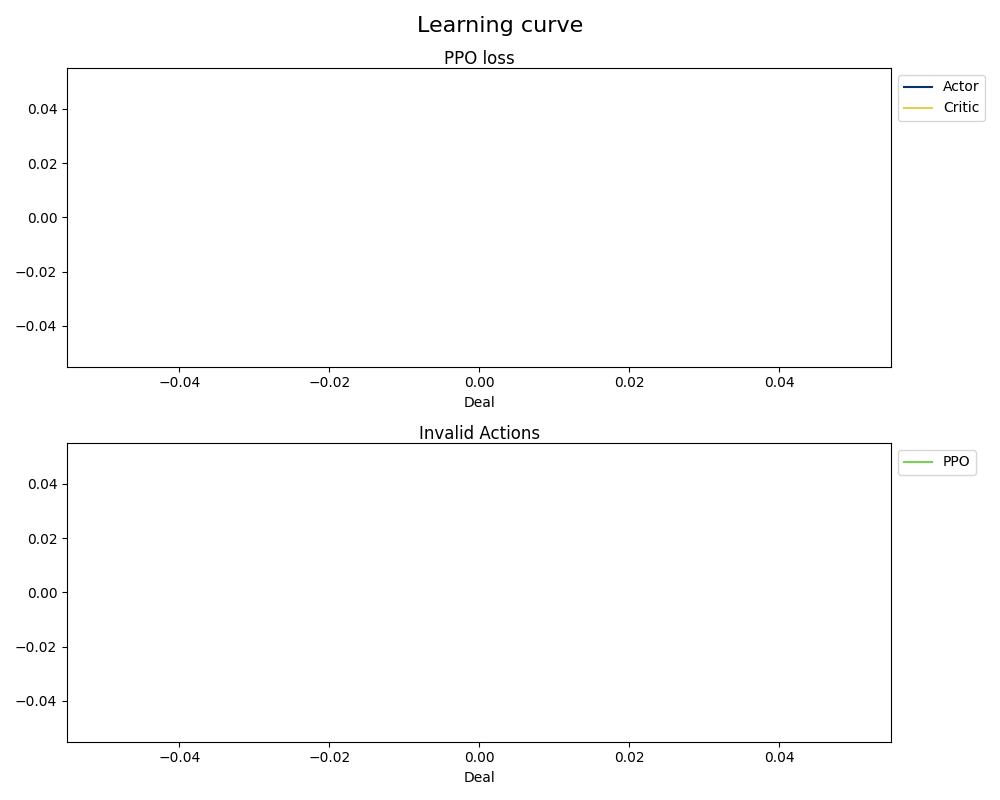

In [9]:
loop = tqdm(range(10000), desc="Episodes", position=0)
plot = LearningCurvePlot(plot_names=['PPO loss', "Invalid Actions"],
                         line_names={'PPO loss':['Actor', 'Critic'] , 'Invalid Actions':['PPO']},
                         line_colors={'PPO loss':[cividis(0.1), cividis(0.9)], 'Invalid Actions':[viridis(0.8)]},
                         x_label='Deal')
ppo_agent.set_loss_callback(lambda x: plot_loss_ppo(x, ppo_agent, plot))
ppo_agent.set_invalid_actions_callback(lambda x: plot_invalid_actions(x, ppo_agent, plot))

async def learn():
    await asyncio.sleep(1)
    for _ in loop:
        game.start()
        loop.set_postfix({"PPO Actor loss":ppo_agent.losses[-1][0] if ppo_agent.losses else float('inf'), "PPO Critic loss":ppo_agent.losses[-1][1] if ppo_agent.losses else float('inf')})
        await asyncio.sleep(0.1)

task = asyncio.get_event_loop().create_task(learn())

In [10]:
await task

Upgraded ppo-actor loss to: 0.353513046191383
Upgraded ppo-critic loss to: 0.4218417052981079
Upgraded ppo-actor loss to: 0.3450984719071033
Upgraded ppo-critic loss to: 0.36018786541001657
Upgraded ppo-critic loss to: 0.31349701732481583
Upgraded ppo-critic loss to: 0.28106958162355056
Upgraded ppo-critic loss to: 0.25244886565543373
Upgraded ppo-critic loss to: 0.23636325480187587
Upgraded ppo-critic loss to: 0.15213785856144071
Upgraded ppo-critic loss to: 0.14065984536055964
Upgraded ppo-critic loss to: 0.10687062824309099
Upgraded ppo-actor loss to: 0.33549799735237334
Upgraded ppo-critic loss to: 0.10065662127764748
Upgraded ppo-actor loss to: 0.3233988826496923
Upgraded ppo-critic loss to: 0.04897803174060133
Upgraded ppo-actor loss to: 0.321802573529108
Upgraded ppo-actor loss to: 0.30482941226559657
Upgraded ppo-actor loss to: 0.2830159109530325
Upgraded ppo-actor loss to: 0.27317347607192927
Upgraded ppo-actor loss to: 0.2543414429759278
Upgraded ppo-actor loss to: 0.24153612

CancelledError: 

In [ ]:
agent = ACAgent(False, 1e-3, 1e-3, actor_layers=[256, 256, 128, 64], critic_layers=[256, 256, 128, 64], gamma=0.99999995)
agent_2 = REINFORCEAgent(128, False, 3e-7, 3e-6, importance_weighting=True, queue_size=524288, baseline_layers=[256, 256, 128, 64], layers=[256, 256, 128, 64])
players = []
for i in range(2):
    # p = REINFORCEAgent(128, False, 5e-3, layers=[256, 256, 128, 64], queue_size=42024, importance_weighting=True)
    # p.qnet = t.load("reinforce_256_128_128_64_small_deck.pkt")
    # p.toggle_training(False)
    # p.requires_grad_(False)
    # p.eval()
    # players.append(p)
    players.append(RandomPlayer())

game = CardGame(agent, agent_2, *players, full_deck=False, display=False)

In [ ]:
agent_2

REINFORCEAgent(
  (qnet): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=24, bias=True)
      (1): Identity()
    )
  )
  (baseline): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_f

In [ ]:
agent

ACAgent(
  (actor): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=24, bias=True)
      (1): Identity()
    )
  )
  (critic): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=

Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

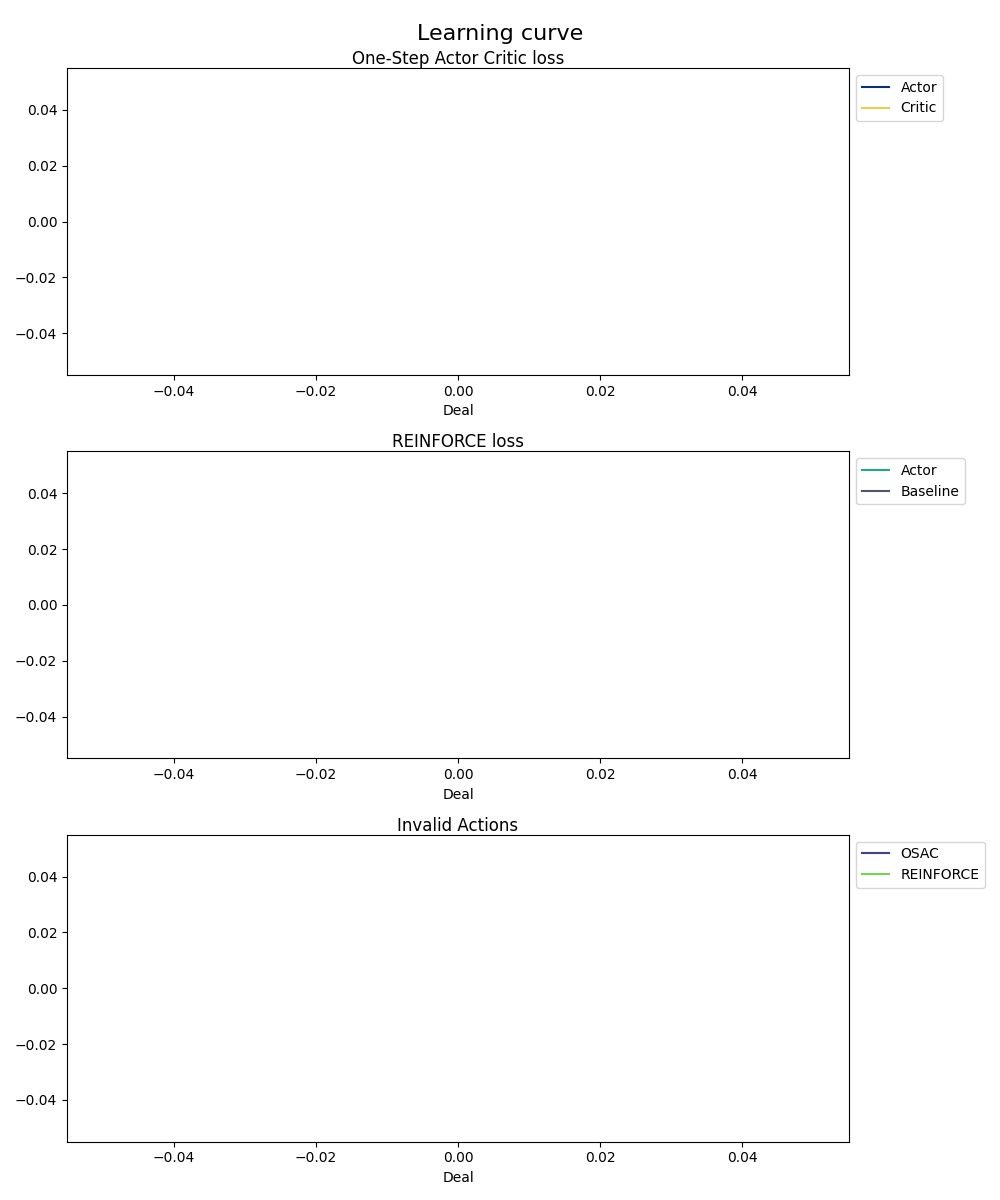

In [ ]:
loop = tqdm(range(10000), desc="Episodes", position=0)
plot = LearningCurvePlot(plot_names=['One-Step Actor Critic loss', 'REINFORCE loss', "Invalid Actions"],
                         line_names={'One-Step Actor Critic loss':['Actor', 'Critic'], 'REINFORCE loss':['Actor', 'Baseline'], 'Invalid Actions':['OSAC', 'REINFORCE']},
                         line_colors={'One-Step Actor Critic loss':[cividis(0.1), cividis(0.9)], 'REINFORCE loss':[viridis(0.6), cividis(0.3)], 'Invalid Actions':[viridis(0.2), viridis(0.8)]},
                         x_label='Deal')
agent.set_loss_callback(lambda x: plot_loss_ac(x, agent, plot))
agent.set_invalid_actions_callback(lambda x: plot_invalid_actions(x, agent, plot))
agent_2.set_loss_callback(lambda x: plot_loss(x, agent_2, plot))
agent_2.set_invalid_actions_callback(lambda x: plot_invalid_actions(x, agent_2, plot))

async def learn():
    await asyncio.sleep(1)
    for _ in loop:
        game.start()
        loop.set_postfix({'REINFORCE loss':agent_2.losses[-1] if agent_2.losses else float('inf'), "Actor loss":agent.losses[-1][0] if agent.losses else float('inf'), "Critic loss":agent.losses[-1][1] if agent.losses else float('inf')})
        await asyncio.sleep(0.1)

task = asyncio.get_event_loop().create_task(learn())

In [ ]:
await task

Upgraded actor loss to: 558.204534153989
Upgraded critic loss to: 175.96982321490415
Upgraded loss to: 0.27368782048674445
Upgraded baseline loss to: 0.38521870811369524
Upgraded loss to: 0.19241386835518098
Upgraded loss to: 0.1508149502200994
Upgraded critic loss to: 160.99069411569351
Upgraded loss to: 0.06914239196727967
Upgraded critic loss to: 160.12518091815045
Upgraded critic loss to: 157.14031803303016
Upgraded critic loss to: 154.7555044857344
Upgraded loss to: 0.025719649170386993
Upgraded critic loss to: 153.5900867457664
Upgraded critic loss to: 153.20649304024482
Upgraded critic loss to: 152.30752527832666
Upgraded critic loss to: 141.2117941462465
Upgraded loss to: 0.01595951024464412
Upgraded critic loss to: 140.10083103226498
Upgraded critic loss to: 134.06213094518873
Upgraded critic loss to: 131.65330934503993
Upgraded baseline loss to: 0.38459737018161916
Upgraded critic loss to: 131.44506975386008
Upgraded critic loss to: 129.94917349153437
Upgraded critic loss to:

CancelledError: 

In [ ]:
agent.training = False
agent.set_loss_callback(lambda x:x)

In [ ]:
agent.actor = t.load('ac_actor.pkt')
agent.critic = t.load('ac_critic.pkt')

In [ ]:
EVAL_EPISODES = 1000

Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Win ratio: 30.3%


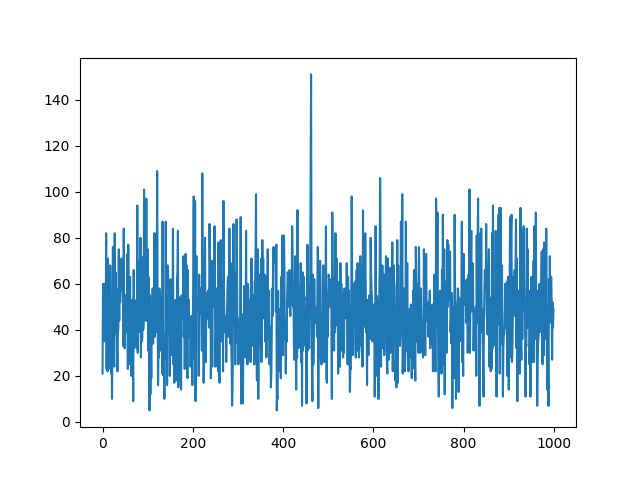

In [ ]:
game = CardGame(agent, RandomPlayer(), RandomPlayer(), RandomPlayer(), full_deck=False, display=False)
wins = 0
rewards = []
test_loop = tqdm(range(EVAL_EPISODES), desc='Episodes')
for _ in test_loop:
	points = game.start()
	wins += int(np.min(list(points.values())) == points[agent])
	rewards.append(points[agent])
print(f"Win ratio: {wins/(EVAL_EPISODES/100)}%")
plt.figure()
plt.plot(rewards)
plt.show()

In [ ]:
agent_2.training = False
agent_2.set_loss_callback(lambda x:x)
agent_2.qnet = t.load('reinforce.pkt')

Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Win ratio REINFORCE: 26.0%


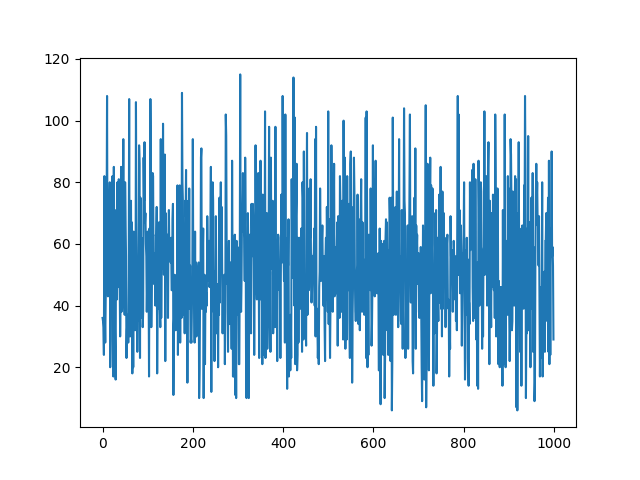

In [ ]:
wins = 0
reinforce_wins = 0
rewards = []
reinforce_rewards = []
game = CardGame(agent_2,RandomPlayer(), RandomPlayer(), RandomPlayer(), full_deck=False, display=False)
test_loop = tqdm(range(EVAL_EPISODES), desc='Episodes')
for _ in test_loop:
	points = game.start()
    
	#wins += int(np.min(list(points.values())) == points[agent])
	reinforce_wins += int(np.min(list(points.values())) == points[agent_2])
	#rewards.append(points[agent])
	reinforce_rewards.append(points[agent_2])
	
	
#print(f"Win ratio AC: {wins/(EVAL_EPISODES/100)}%")
print(f"Win ratio REINFORCE: {reinforce_wins/(EVAL_EPISODES/100)}%")
plt.figure()
#plt.plot(rewards)
plt.plot(reinforce_rewards)

Win ratio AC: 30.9%
Win ratio REINFORCE: 28.2%


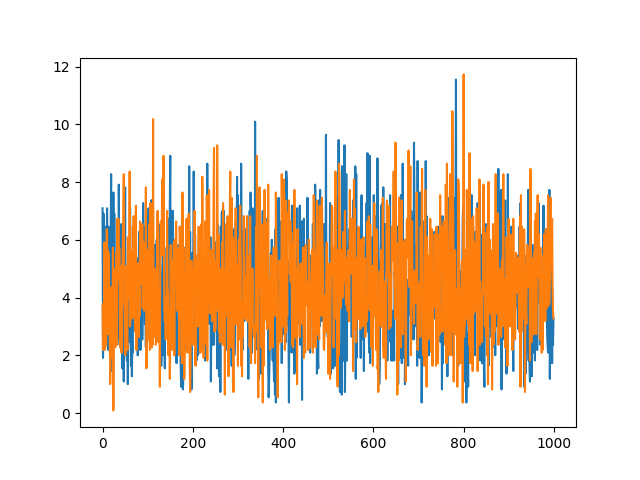

In [ ]:
print(f"Win ratio AC: {wins/(EVAL_EPISODES/100)}%")
print(f"Win ratio REINFORCE: {reinforce_wins/(EVAL_EPISODES/100)}%")
plt.figure()
plt.plot(np.asarray(rewards)/11)
plt.plot(np.asarray(reinforce_rewards)/11)

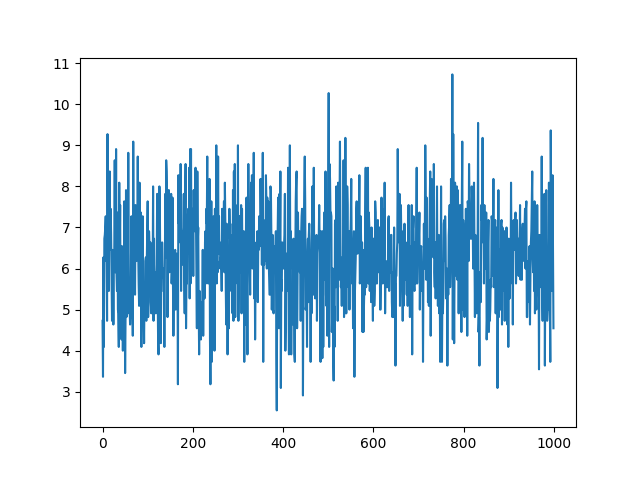

In [ ]:
plt.clf()
plt.figure()
plt.plot(np.asarray(agent.invalid_actions_per_episode[-1000:])/11)

In [ ]:
import matplotlib.pyplot as plt
import asyncio


fig = plt.figure()

async def update():
    for i in range(5):
        print(i)
        x = list(range(i + 2))
        xx = [x**2 for x in x]
        plt.clf()
        plt.plot(x, xx)
        fig.canvas.draw()
        await asyncio.sleep(1)


loop = asyncio.get_event_loop()
loop.create_task(update());